<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: [Arseny Kravchenko](http://arseny.info/pages/about-me.html), Head of R&D at Wannaby <br>
Translated and edited by [Christina Butsko](https://www.linkedin.com/in/christinabutsko/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), [Anna Larionova](https://www.linkedin.com/in/anna-larionova-74434689/), [Evgeny Sushko](https://www.linkedin.com/in/evgenysushko/) and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/).

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

# <center> Topic 6. Feature Engineering and Feature Selection</center>
In this course, we have already seen several key machine learning algorithms. However, before moving on to the more fancy ones, we’d like to take a small detour and talk about data preparation. The well-known concept of “garbage in — garbage out” applies 100% to any task in machine learning. Any experienced professional can recall numerous times when a simple model trained on high-quality data was proven to be better than a complicated multi-model ensemble built on data that wasn’t clean.

To start, I wanted to review three similar but different tasks:
* **feature extraction** and **feature engineering**: transformation of raw data into features suitable for modeling;
* **feature transformation**: transformation of data to improve the accuracy of the algorithm;
* **feature selection**: removing unnecessary features.

This article will contain almost no math, but there will be a fair amount of code. Some examples will use the dataset from Renthop company, which is used in the [Two Sigma Connect: Rental Listing Inquiries Kaggle competition](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries). In this task, you need to predict the popularity of a new rental listing, i.e. classify the listing into three classes: `['low', 'medium' , 'high']`. To evaluate the solutions, we will use the log loss metric (the smaller, the better). Those who do not have a Kaggle account, will have to register; you will also need to accept the rules of the competition in order to download the data.

In [56]:
import json
import pandas as pd

# Let's load the dataset from Renthop right away
with open('../../data/train.json', 'r') as raw_data:
    data = json.load(raw_data)
    df = pd.DataFrame(data)

## Article outline

1. Feature Extraction
        1. Texts
        2. Images
        3. Geospatial data
        4. Date and time
        5. Time series, web, etc.

2. Feature transformations
        1. Normalization and changing distribution
        2. Interactions
        3. Filling in the missing values

3. Feature selection
        1. Statistical approaches
        2. Selection by modeling
        3. Grid search

## Feature Extraction

In practice, data rarely comes in the form of ready-to-use matrices. That's why every task begins with feature extraction. Sometimes, it can be enough to read the csv file and convert it into `numpy.array`, but this is a rare exception. Let's look at some of the popular types of data from which features can be extracted.

### Texts

Text is a type of data that can come in different formats; there are so many text processing methods that cannot fit in a single article. Nevertheless, we will review the most popular ones.

Before working with text, one must tokenize it. Tokenization implies splitting the text into units (hence, tokens). Most simply, tokens are just the words. But splitting by word can lose some of the meaning -- "Santa Barbara" is one token, not two, but "rock'n'roll" should not be split into two tokens. There are ready-to-use tokenizers that take into account peculiarities of the language, but they make mistakes as well, especially when you work with specific sources of text (newspapers, slang, misspellings, typos).

After tokenization, you will normalize the data. For text, this is about stemming and/or lemmatization; these are similar processes used to process different forms of a word. One can read about the difference between them [here](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).

So, now that we have turned the document into a sequence of words, we can represent it with vectors. The easiest approach is called Bag of Words: we create a vector with the length of the dictionary, compute the number of occurrences of each word in the text, and place that number of occurrences in the appropriate position in the vector. The process described looks simpler in code:

In [2]:
from functools import reduce 
import numpy as np

texts = [['i', 'have', 'a', 'cat'], 
        ['he', 'have', 'a', 'dog'], 
        ['he', 'and', 'i', 'have', 'a', 'cat', 'and', 'a', 'dog']]

dictionary = list(enumerate(set(list(reduce(lambda x, y: x + y, texts)))))

def vectorize(text): 
    vector = np.zeros(len(dictionary)) 
    for i, word in dictionary: 
        num = 0 
        for w in text: 
            if w == word: 
                num += 1 
        if num: 
            vector[i] = num 
    return vector

for t in texts: 
    print(vectorize(t))

[ 1.  1.  0.  1.  1.  0.  0.]
[ 1.  0.  1.  1.  0.  0.  1.]
[ 2.  1.  1.  1.  1.  2.  1.]


Here is an illustration of the process:

![image](../../img/bag_of_words.png)

This is an extremely naive implementation. In practice, you need to consider stop words, the maximum length of the dictionary, more efficient data structures (usually text data is converted to a sparse vector), etc.

When using algorithms like Bag of Words, we lose the order of the words in the text, which means that the texts "i have no cows" and "no, i have cows" will appear identical after vectorization when, in fact, they have the opposite meaning. To avoid this problem, we can revisit our tokenization step and use N-grams (the *sequence* of N consecutive tokens) instead.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,1))
vect.fit_transform(['no i have cows', 'i have no cows']).toarray()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int64)

In [4]:
vect.vocabulary_ 

{'cows': 0, 'have': 1, 'no': 2}

In [46]:
vect = CountVectorizer(ngram_range=(2,3), analyzer='word')
vect.fit_transform(['no i have cows', 'i have no cows']).toarray()

array([[1, 0, 0, 0, 1, 1],
       [0, 1, 1, 1, 0, 0]], dtype=int64)

In [47]:
vect.vocabulary_

{'have cows': 0,
 'have no': 1,
 'have no cows': 2,
 'no cows': 3,
 'no have': 4,
 'no have cows': 5}

Also note that one does not have to use only words. In some cases, it is possible to generate N-grams of characters. This approach would be able to account for similarity of related words or handle typos.

In [32]:
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(3,3), analyzer='char_wb')

n1, n2, n3, n4 = vect.fit_transform(['andersen', 'petersen', 'petrov', 'smith']).toarray()

euclidean(n1, n2), euclidean(n2, n3), euclidean(n3, n4)

(2.8284271247461903, 3.1622776601683795, 3.3166247903553998)

In [33]:
n1

array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0], dtype=int64)

In [15]:
vect.fit_transform(['andrew']).toarray()

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int64)

In [34]:
vect.vocabulary_

{' an': 0,
 ' pe': 1,
 ' sm': 2,
 'and': 3,
 'der': 4,
 'en ': 5,
 'ers': 6,
 'ete': 7,
 'etr': 8,
 'ith': 9,
 'mit': 10,
 'nde': 11,
 'ov ': 12,
 'pet': 13,
 'rov': 14,
 'rse': 15,
 'sen': 16,
 'smi': 17,
 'ter': 18,
 'th ': 19,
 'tro': 20}

Adding onto the Bag of Words idea: words that are rarely found in the corpus (in all the documents of this dataset) but are present in this particular document might be more important. Then it makes sense to increase the weight of more domain-specific words to separate them out from common words. This approach is called TF-IDF (term frequency-inverse document frequency), which cannot be written in a few lines, so you should look into the details in references such as [this wiki](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). The default option is as follows:

$$ \large idf(t,D) = \log\frac{\mid D\mid}{df(d,t)+1} $$

$$ \large tfidf(t,d,D) = tf(t,d) \times idf(t,D) $$

Analogs of Bag of Words can be found outside of text problems e.g. bag of sites in the [Catch Me If You Can competition](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking), [bag of apps](https://www.kaggle.com/xiaoml/talkingdata-mobile-user-demographics/bag-of-app-id-python-2-27392), [bag of events](http://www.interdigital.com/download/58540a46e3b9659c9f000372), etc.

![image](../../img/bag_of_words.png)

Using these algorithms, it is possible to obtain a working solution for a simple problem, which can serve as a baseline. However, for those who do not like the classics, there are new approaches. The most popular method in the new wave is Word2Vec, but there are a few alternatives as well (GloVe, Fasttext, etc.).

Word2Vec is a special case of the word embedding algorithms. Using Word2Vec and similar models, we can not only vectorize words in a high-dimensional space (typically a few hundred dimensions) but also compare their semantic similarity. This is a classic example of operations that can be performed on vectorized concepts: king - man + woman = queen.

![image](https://cdn-images-1.medium.com/max/800/1*K5X4N-MJKt8FGFtrTHwidg.gif)

It is worth noting that this model does not comprehend the meaning of the words but simply tries to position the vectors such that words used in common context are close to each other. If this is not taken into account, a lot of fun examples will come up.

Such models need to be trained on very large datasets in order for the vector coordinates to capture the semantics. A pretrained model for your own tasks can be downloaded [here](https://github.com/3Top/word2vec-api#where-to-get-a-pretrained-models).

Similar methods are applied in other areas such as bioinformatics. An unexpected application is [food2vec](https://jaan.io/food2vec-augmented-cooking-machine-intelligence/). You can probably think of a few other fresh ideas; the concept is universal enough.

### Images

Working with images is easier and harder at the same time. It is easier because it is possible to just use one of the popular pretrained networks without much thinking but harder because, if you need to dig into the details, you may end up going really deep. Let's start from the beginning.

In a time when GPUs were weaker and the "renaissance of neural networks" had not happened yet, feature generation from images was its own complex field. One had to work at a low level, determining corners, borders of regions, color distributions statistics, and so on. Experienced specialists in computer vision could draw a lot of parallels between older approaches and neural networks; in particular, convolutional layers in today's networks are similar to [Haar cascades](https://en.wikipedia.org/wiki/Haar-like_feature). If you are interested in reading more, here are a couple of links to some interesting libraries: [skimage](http://scikit-image.org/docs/stable/api/skimage.feature.html) and [SimpleCV](http://simplecv.readthedocs.io/en/latest/SimpleCV.Features.html).

Often for problems associated with images, a convolutional neural network is used. You do not have to come up with the architecture and train a network from scratch. Instead, download a pretrained state-of-the-art network with the weights from public sources. Data scientists often do so-called fine-tuning to adapt these networks to their needs by "detaching" the last fully connected layers of the network, adding new layers chosen for a specific task, and then training the network on new data. If your task is to just vectorize the image (for example, to use some non-network classifier), you only need to remove the last layers and use the output from the previous layers:

In [48]:
# Install Keras (https://keras.io/)
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image 
from scipy.misc import face 
import numpy as np

resnet_settings = {'include_top': False, 'weights': 'imagenet'}
resnet = ResNet50(**resnet_settings)

# What a cute raccoon!
img = image.array_to_img(face())
img

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
D:\ML\tools\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


AttributeError: module 'theano' has no attribute 'ifelse'

In [9]:
# In real life, you may need to pay more attention to resizing
img = img.resize((224, 224))

x = image.img_to_array(img) 
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Need an extra dimension because model is designed to work with an array
# of images - i.e. tensor shaped (batch_size, width, height, n_channels)

features = resnet.predict(x)

![image](https://cdn-images-1.medium.com/max/800/1*Iw_cKFwLkTVO2SPrOZU2rQ.png)

*Here's a classifier trained on one dataset and adapted for a different one by "detaching" the last layer and adding a new one instead.*

Nevertheless, we should not focus too much on neural network techniques. Features generated by hand are still very useful: for example, for predicting the popularity of a rental listing, we can assume that bright apartments attract more attention and create a feature such as "the average value of the pixel". You can find some inspiring examples in the documentation of [relevant libraries](http://pillow.readthedocs.io/en/3.1.x/reference/ImageStat.html).

If there is text on the image, you can read it without unraveling a complicated neural network. For example, check out [pytesseract](https://github.com/madmaze/pytesseract).

```python
import pytesseract
from PIL import Image
import requests
from io import BytesIO

##### Just a random picture from search
img = 'http://ohscurrent.org/wp-content/uploads/2015/09/domus-01-google.jpg'

img = requests.get(img)
img = Image.open(BytesIO(img.content))
text = pytesseract.image_to_string(img)

text

Out: 'Google'
```

In [54]:
import Image

ModuleNotFoundError: No module named 'Image'

In [52]:
import pytesseract

ImportError: DLL load failed: Не найден указанный модуль.

In [51]:
from PIL import Image
import requests
from io import BytesIO

##### Just a random picture from search
img = 'http://ohscurrent.org/wp-content/uploads/2015/09/domus-01-google.jpg'

img = requests.get(img)
img = Image.open(BytesIO(img.content))
text = pytesseract.image_to_string(img)

text

ImportError: DLL load failed: Не найден указанный модуль.

One must understand that `pytesseract` is not a solution for everything.

```python
##### This time we take a picture from Renthop
img = requests.get('https://photos.renthop.com/2/8393298_6acaf11f030217d05f3a5604b9a2f70f.jpg')
img = Image.open(BytesIO(img.content))
pytesseract.image_to_string(img)

Out: 'Cunveztible to 4}»'
```

Another case where neural networks cannot help is extracting features from meta-information. For images, EXIF stores many useful meta-information: manufacturer and camera model, resolution, use of the flash, geographic coordinates of shooting, software used to process image and more.

### Geospatial data

Geographic data is not so often found in problems, but it is still useful to master the basic techniques for working with it, especially since there are quite a number of ready-to-use solutions in this field.

Geospatial data is often presented in the form of addresses or coordinates of (Latitude, Longitude). Depending on the task, you may need two mutually-inverse operations: geocoding (recovering a point from an address) and reverse geocoding (recovering an address from a point). Both operations are accessible in practice via external APIs from Google Maps or OpenStreetMap. Different geocoders have their own characteristics, and the quality varies from region to region. Fortunately, there are universal libraries like [geopy](https://github.com/geopy/geopy) that act as wrappers for these external services.

If you have a lot of data, you will quickly reach the limits of external API. Besides, it is not always the fastest to receive information via HTTP. Therefore, it is necessary to consider using a local version of OpenStreetMap.

If you have a small amount of data, enough time, and no desire to extract fancy features, you can use `reverse_geocoder` in lieu of OpenStreetMap:

```python
import reverse_geocoder as revgc

revgc.search((df.latitude, df.longitude))
Loading formatted geocoded file... 

Out: [OrderedDict([('lat', '40.74482'), 
                   ('lon', '-73.94875'), 
                   ('name', 'Long Island City'), 
                   ('admin1', 'New York'), 
                   ('admin2', 'Queens County'), 
                   ('cc', 'US')])]
```

When working with geoсoding, we must not forget that addresses may contain typos, which makes the data cleaning step necessary. Coordinates contain fewer misprints, but its position can be incorrect due to GPS noise or bad accuracy in places like tunnels, downtown areas, etc. If the data source is a mobile device, the geolocation may not be determined by GPS but by WiFi networks in the area, which leads to holes in space and teleportation. While traveling along in Manhattan, there can suddenly be a WiFi location from Chicago.

> WiFi location tracking is based on the combination of SSID and MAC-addresses, which may correspond to different points e.g. federal provider standardizes the firmware of routers up to MAC-address and places them in different cities. Even a company's move to another office with its routers can cause issues.

The point is usually located among infrastructure. Here, you can really unleash your imagination and invent features based on your life experience and domain knowledge: the proximity of a point to the subway, the number of stories in the building, the distance to the nearest store, the number of ATMs around, etc. For any task, you can easily come up with dozens of features and extract them from various external sources. For problems outside an urban environment, you may consider features from more specific sources e.g. the height above sea level.

If two or more points are interconnected, it may be worthwhile to extract features from the route between them. In that case, distances (great circle distance and road distance calculated by the routing graph), number of turns with the ratio of left to right turns, number of traffic lights, junctions, and bridges will be useful. In one of my own tasks, I generated a feature called "the complexity of the road", which computed the graph-calculated distance divided by the GCD.

### Date and time

You would think that date and time are standardized because of their prevalence, but, nevertheless, some pitfalls remain.

Let's start with the day of the week, which are easy to turn into 7 dummy variables using one-hot encoding. In addition, we will also create a separate binary feature for the weekend called `is_weekend`.

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 7.3+ MB


In [60]:
df['dow'] = df['created'].apply(lambda x: x.date().weekday())

AttributeError: 'str' object has no attribute 'date'

In [57]:
df['is_weekend'] = df['created'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

AttributeError: 'str' object has no attribute 'date'

Some tasks may require additional calendar features. For example, cash withdrawals can be linked to a pay day; the purchase of a metro card, to the beginning of the month. In general, when working with time series data, it is a good idea to have a calendar with public holidays, abnormal weather conditions, and other important events.

> Q: What do Chinese New Year, the New York marathon, and the Trump inauguration have in common?

> A: They all need to be put on the calendar of potential anomalies.

Dealing with hour (minute, day of the month ...) is not as simple as it seems. If you use the hour as a real variable, we slightly contradict the nature of data: `0<23` while `0:00:00 02.01> 01.01 23:00:00`. For some problems, this can be critical. At the same time, if you encode them as categorical variables, you'll breed a large numbers of features and lose information about proximity -- the difference between 22 and 23 will be the same as the difference between 22 and 7.

There also exist some more esoteric approaches to such data like projecting the time onto a circle and using the two coordinates.

In [10]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period 
    return np.cos(value), np.sin(value)

This transformation preserves the distance between points, which is important for algorithms that estimate distance (kNN, SVM, k-means ...)

In [11]:
from scipy.spatial import distance
euclidean(make_harmonic_features(23), make_harmonic_features(1)) 

0.5176380902050424

In [12]:
euclidean(make_harmonic_features(9), make_harmonic_features(11)) 

0.5176380902050414

In [13]:
euclidean(make_harmonic_features(9), make_harmonic_features(21))

2.0

However, the difference between such coding methods is down to the third decimal place in the metric.

### Time series, web, etc.

Regarding time series — we will not go into too much detail here (mostly due to my personal lack of experience), but I will point you to a [useful library that automatically generates features for time series](https://github.com/blue-yonder/tsfresh).

If you are working with web data, then you usually have information about the user's User Agent. It is a wealth of information. First, one needs to extract the operating system from it. Secondly, make a feature `is_mobile`. Third, look at the browser.

In [63]:
# Install pyyaml ua-parser user-agents
import user_agents

ua = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/56.0.2924.76 Chrome/56.0.2924.76 Safari/537.36'
ua = user_agents.parse(ua)

print('Is a bot? ', ua.is_bot)
print('Is mobile? ', ua.is_mobile)
print('Is PC? ',ua.is_pc)
print('OS Family: ',ua.os.family)
print('OS Version: ',ua.os.version)
print('Browser Family: ',ua.browser.family)
print('Browser Version: ',ua.browser.version)

ModuleNotFoundError: No module named 'user_agents'

> As in other domains, you can come up with your own features based on intuition about the nature of the data. At the time of this writing, Chromium 56 was new, but, after some time, only users who haven't rebooted their browser for a long time will have this version. In this case, why not introduce a feature called "lag behind the latest version of the browser"?

In addition to the operating system and browser, you can look at the referrer (not always available), [http_accept_language](https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/Accept-Language), and other meta information.

The next useful piece of information is the IP-address, from which you can extract the country and possibly the city, provider, and connection type (mobile/stationary). You need to understand that there is a variety of proxy and outdated databases, so this feature can contain noise. Network administration gurus may try to extract even fancier features like suggestions for [using VPN](https://habrahabr.ru/post/216295/). By the way, the data from the IP-address is well combined with `http_accept_language`: if the user is sitting at the Chilean proxies and browser locale is `ru_RU`, something is unclean and worth a look in the corresponding column in the table (`is_traveler_or_proxy_user`).

Any given area has so many specifics that it is too much for an individual to absorb completely. Therefore, I invite everyone to share their experiences and discuss feature extraction and generation in the comments section.

## Feature transformations

### Normalization and changing distribution

Monotonic feature transformation is critical for some algorithms and has no effect on others. This is one of the reasons for the increased popularity of decision trees and all its derivative algorithms (random forest, gradient boosting). Not everyone can or want to tinker with transformations, and these algorithms are robust to unusual distributions.

There are also purely engineering reasons: `np.log` is a way of dealing with large numbers that do not fit in `np.float64`. This is an exception rather than a rule; often it's driven by the desire to adapt the dataset to the requirements of the algorithm. Parametric methods usually require a minimum of symmetric and unimodal distribution of data, which is not always given in real data. There may be more stringent requirements; recall [our earlier article about linear models](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-4-linear-classification-and-regression-44a41b9b5220).

However, data requirements are imposed not only by parametric methods; [K nearest neighbors](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-3-classification-decision-trees-and-k-nearest-neighbors-8613c6b6d2cd) will predict complete nonsense if features are not normalized e.g. when one distribution is located in the vicinity of zero and does not go beyond (-1, 1) while the other’s range is on the order of hundreds of thousands.

A simple example: suppose that the task is to predict the cost of an apartment from two variables — the distance from city center and the number of rooms. The number of rooms rarely exceeds 5 whereas the distance from city center can easily be in the thousands of meters.

The simplest transformation is Standard Scaling (or Z-score normalization):

$$ \large z= \frac{x-\mu}{\sigma} $$

Note that Standard Scaling does not make the distribution normal in the strict sense.

In [65]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import beta
from scipy.stats import shapiro
import numpy as np

data = beta(1, 10).rvs(1000).reshape(-1, 1)
shapiro(data)

(0.8791459202766418, 3.6045335060602184e-27)

In [67]:
data.shape

(1000, 1)

In [16]:
# Value of the statistic, p-value
shapiro(StandardScaler().fit_transform(data))

# With such p-value we'd have to reject the null hypothesis of normality of the data

(0.87336665391922, 1.0237810250125059e-27)

But, to some extent, it protects against outliers:

In [68]:
data = np.array([1, 1, 0, -1, 2, 1, 2, 3, -2, 4, 100]).reshape(-1, 1).astype(np.float64)

In [69]:
data

array([[   1.],
       [   1.],
       [   0.],
       [  -1.],
       [   2.],
       [   1.],
       [   2.],
       [   3.],
       [  -2.],
       [   4.],
       [ 100.]])

In [71]:
StandardScaler().fit_transform(data)

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

In [70]:
(data - data.mean()) / data.std()

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

Another fairly popular option is MinMax Scaling, which brings all the points within a predetermined interval (typically (0, 1)).

$$ \large X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}} $$

In [81]:
from sklearn.preprocessing import MinMaxScaler

In [80]:
MinMaxScaler().fit_transform(data)

ValueError: Expected 2D array, got 1D array instead:
array=[  2.58789394   0.20140037   0.55356878   1.51390002   2.55922807
   1.20936016   0.39961633   0.48818408   0.43794207   1.88965793
   0.64731034   1.01638686   1.68808205   0.38110312   0.31844678
   3.51238445   0.15357974   0.95599045   5.05480696   0.23547589
   0.92240224   2.51959831   4.19972244   0.6167542    2.81517233
   0.0637475    1.21802116   1.23606251   1.30689578   0.77066838
   0.8651784    4.08617162   1.06950438   1.84397105   2.08280708
   0.6223739    1.26911393   0.69866421   2.17701388   2.16719538
   2.69852763   1.55951742   1.29167426   1.38435613   5.08324676
   2.27689627   1.12098771   0.73088314   1.58517247   0.13804551
   2.99381572   1.27390006   5.22505902   0.28107427   0.48390931
   1.95078409   1.44499231   0.2062888    0.26244727   0.63092269
   2.92516043   0.5565309    1.05357218   2.16556972   1.28588235
   0.15168452   1.5492804    0.38064221   1.53747942   0.74831961
   0.864102     0.34570735   0.66366169   0.65256748   1.69023687
   4.15087742   6.50376507   1.40854598   0.89164461   0.95794856
   1.11910945   0.51567272   1.58815853   1.03456491   0.86551863
   0.56196883   1.55973335   0.81951026   0.58294815   1.29608062
  16.60729032   0.73004902   0.35658438   0.44365767   0.57503976
   0.73183627   2.72152375   0.16304558   1.8442656    0.86357041
   1.60065252   5.84338744   0.391954     0.78162523   3.20223243
   0.90683485   0.52727542   2.19906274   1.36626068   1.58496551
   0.13790678   1.63859259   0.76329734   2.58436672   0.54400844
   5.102586     5.04930153   1.53415829   0.70822174   1.30541824
   0.68931102   1.06350907   0.53985408   0.8608931    4.86509339
   9.46849425   1.88100714   1.77310495   1.89323281   0.2985907
   8.0448271    0.12112198   1.06834248   0.04562355   7.75243998
   0.37439861   0.32386904   0.41552059   0.43425035   0.69840813
   5.23802524   0.71724738   1.01977344   0.85267578   0.53942533
   1.60185275   2.25345271   1.07336694   1.03445742   0.31958555
   0.45974754   0.37601611   1.16718715   0.1470965    5.48352255
   2.72804276   0.41444518   1.79911435   0.15431731   1.49576012
   2.16175652   0.32340581   1.33883346   1.38175045   1.55516593
   0.48483265   1.04880306   0.72479637   0.32924895   0.60551049
   1.5756681    4.30794955   3.82079099   0.41331963   1.14705315
   5.27562062   2.70261368   0.86899888   0.73311662   0.58210253
   0.26492591   0.20806627   2.03390417   2.87029323   0.17978431
   0.99668671   0.33985766   1.06817166   1.73131077   1.81101568
   0.87895015   0.55918208   1.52618586   1.82706815   0.28935613
   2.45561528   0.83951254   1.18872598   1.47449191   0.38297624
   2.1472051    0.48988717   0.70091416   0.72246947   0.14923807
   0.37826518   2.30236629   1.18847352   4.22244616   2.55719837
   0.8125967    0.36578829   2.0868156    2.13055534   0.55819201
   1.41103207   2.37297715   0.4384191    1.50723967   5.12138246
   0.34448535   6.81349512   3.32813195   4.96215841   5.05069937
   1.34616978   0.61434278   1.12388565   0.57768969   2.37825701
   9.12997277   0.67469823   0.89182511   0.13806382   6.44162006
   1.1144617    0.40980493   0.50765729   1.46000262   0.48600747
   0.83586993   1.21514971   0.40118182   0.66869216   0.15081544
   1.92746276   1.89525027   4.2364851    0.72763837   1.43779754
   1.39305608   0.83615091   2.70582408   4.94934889   2.02602095
   0.71867066   1.70926476   0.39461585   0.42197296   2.66765026
   0.57806307   1.75908683   0.74135089   0.97385268   0.28341452
   2.11286395   1.14641412   0.77498917   0.21439251   1.06893486
   0.52241024   2.69185751   0.24515425   1.02837593   0.93614224
   0.36597363   0.37592186   1.80817973   2.45099205   0.14696563
   1.00333829   0.51485634   2.05898747   0.44257704   0.52838739
   0.86566073   9.1893536    5.68731545   0.78726577   4.66762422
   0.20457944   1.02522424   0.19541008   0.61351418   2.38736655
   5.33567037   0.35574259   0.28725544   1.50475014   2.84047465
  11.14909485   0.37408253   0.93993899   0.84428649   0.34644774
   1.27392701   0.52680988   1.86476703   1.23479178   1.24649713
   0.7935796    2.55096495   4.24258727   0.4385068    0.60965999
   0.2990796    3.97947558   0.16363248   3.16412646   1.69031438
   1.26340451   0.4073965    0.79647729   3.45974398   0.41062631
   1.86657791   1.05160968   0.55192717   0.82194453   0.31469172
   0.65699952   0.56103741   1.48426568   7.51374474   1.99283617
   7.04651079   0.40645062   2.44513436   0.58515397   0.2714397
   3.27489567   8.2099747    0.82072841   0.84002698   0.17707444
   0.62115647   3.35130831   0.62490176   1.64341835   0.15731641
   0.65666374   0.16930404   1.23627175   0.46486245   1.73212222
   1.14385165   7.01583715   1.67619416   0.73706611   0.34721675
   2.66055238   0.78716332   2.61067714   2.30898944   1.45684881
   1.73630757   5.91593861   0.11749427   1.08757304   0.33349331
   1.87188768   2.09480036   5.88195668   0.45279111   0.27175478
   1.28160311   0.39607604   1.66622383   1.92714846   0.54362322
   0.92601344   0.19716241   3.64583699   1.12016796   0.83465092
   0.68901046   4.38550364   1.29262872   6.12057663   0.99097579
   0.52776282   3.19947953   0.30383051   1.45131153   0.28776072
   0.49135081   0.45317332   0.43301531   3.42937142   1.30639403
   0.81907866   3.93592909   0.06778023   9.24141532   0.69750227
   1.68793103   2.30954315   5.16715238   2.33134132   1.41793605
   1.27885137   2.75204061   1.73681633   0.55407314   0.54359324
   1.15082738   0.16502569   2.67702228   1.28821458   0.39175631
   2.93450827   8.35575955   2.0069849    3.01670977   0.85829722
   5.06476556   0.3457671    1.43955186   4.96889815   0.76176647
   1.88910997   0.54140116   0.3294975    0.37402687   1.85875171
   0.31078539   1.12520804   1.0770855    1.9212537    0.82511844
   0.46482691   2.93494423   2.74627594   0.39547469   3.37741433
   1.50785361   2.07161447   0.77732582   0.30138705   0.13152653
   0.52748626   2.84980729   1.27412794   0.60357387   1.21406375
   0.42615259   0.99194346   1.19485702   5.98400603   1.13856087
   3.20028386   0.18470079   0.34586832   3.49104396   1.52229235
   0.88806109   0.30982934   0.98171495   0.80726508  11.26524972
   2.51634089   1.36442876   0.52473079   1.01461586   1.49181032
   0.35950448   0.32605148   0.38861455   0.24932093   1.27615479
   0.94158179   0.58330225   0.4307988    0.59222056   0.2951804
   2.75405797   2.39197627   0.66949835   3.25111459   2.33807122
   0.16195284   2.51721817   1.57996946   2.26183132   0.32779505
   0.53211239   0.14640909   0.67696223   0.29812842   0.8778496
   0.17798694   2.68401872   5.20585057   1.00091747   0.41200845
   0.7935535    2.20814347   1.43215755   5.04180931   0.53730073
   1.39799404   0.46399927   1.07429135   0.24070933   0.19378076
   0.62109419   0.15196261   0.53179855   1.15979778   0.74490832
   0.89705537   0.1637063    1.54645171   1.5398066    0.33898682
   1.22298334   2.27824277   0.73102687   0.13007258   4.72333095
   0.63185273   0.17230461   1.48605652   1.46015823   0.31591806
   0.42899873   8.67375062   2.88384544   0.85475263   0.44780448
   0.98647744   0.41467032   1.00291745   2.44620695   2.73648326
   2.81675716   5.69486691   0.09942439   5.75163613   0.2212929
   0.93939598   0.86019998   2.84076768   1.29875545   2.59359237
   3.57029365   1.68731055   1.037352     0.65300895   2.1219217
   9.79649945   0.14319859   7.13040323   4.53984286  13.94822768
   1.9214901    1.82251871   7.32149562   1.04200388   1.82444315
   0.75806182   1.92659788   0.8447269    0.60974817   0.06315165
   3.50879034   1.60437904   1.35574341   9.97719549   0.62049633
   0.70594515   1.0657646    1.27930102   1.32958      0.55965418
   1.38853752   4.67981409   0.69368613   2.21847287   2.03672456
   0.0899098    1.76531525   1.14762696   0.45971187   0.4162059
   0.69922367   6.82688463  13.57227651   0.34704367   0.80298933
   0.53887594   1.68013137   2.07646663   0.30132351   4.22547802
   2.53397147   0.44697305   0.75308408   0.62091599   0.38005259
   0.2579194    0.78847548   0.73635407   0.54535034   0.23944245
   0.56244685   1.23584967   3.20973166   0.36021045   0.23572224
   2.30292289   0.39050369   4.70942106   0.51332617   1.58068999
   0.53299483   0.35151147   1.05815999   1.03107618   0.78366945
   1.02653313   2.28452106   1.75660639   0.9428456    6.10157489
   0.48856415   1.06921828   1.15161813   2.46725793   1.12612127
   0.83317148   0.05350412   0.38178771   2.8901492    4.18545141
   0.25409707   1.27281345   0.71573596   1.30236559   0.53400919
   0.70334842   1.55485873   0.93015707   2.19769002   0.7882207
   0.58056617   4.00388916   3.0545612    0.73587854  24.88408037
   0.98805679   0.62285174   1.34519355   1.30262871   1.24834398
   1.66370661   0.3715346    0.80251963   1.90677061   1.65284036
   0.65528182   0.47464398   4.03397315   0.24816996   0.42061473
   0.53598204   1.04209163   1.4681573    8.04636465   0.12796704
   0.42488138   0.77258467   0.4560669    2.49173576   1.42502968
   0.22995312   0.21852333   1.8402082    1.15325909   2.56229475
   1.00472703   1.1555205    5.212505     0.92708468   2.05835918
   0.28073265   0.83692175   2.49877249   4.99985314   0.78186493
   1.12151414   5.62788289   4.87778904   1.02792126   3.40068347
   5.95145042   1.25734282   1.3821593    1.54082753   0.06197741
   0.30415076   0.20169528   0.88430955   0.73976861   0.4740544
   1.81433565   0.24309256   1.68582575   3.14986582   0.50622149
   0.42327082   4.00686676   1.87683181   2.5316658    0.8781392
   1.14273976   0.84666298   0.41185657   3.86389681   3.61539823
   3.22951132   1.06743109   1.20550146   0.46232303  12.41075357
   0.17907704   1.3418829    3.2014402    0.36679839   0.40115238
   7.07371875   2.35913748   0.30998707   0.3264285    0.59398925
   1.09283534   0.31592721   1.05071227   0.56549153   1.90296502
   5.92206053   1.29925578   0.22455077   1.22768858   2.10614933
  10.08851782   1.88261905   0.50169378   0.80440197   1.68596754
   1.35010917   2.25573316   0.33103296   2.49553998   1.34270944
   2.8657243    2.80293941   2.02683205   1.90402273   1.31914464
   1.17481186   1.75242983   1.01185067   1.4135332    1.0826946
   0.19508572   0.88107346   1.30463657   0.48219829   1.43272682
   0.59581251   0.74462141   1.6187802    0.37943987   1.52074824
   0.40800283   7.18178818   0.92924853   1.05342786   0.59846412
   8.13701552   0.47921889   4.82351891   0.31177465   2.36410916
   0.75462396   1.18278539   0.08951037   0.57426612   0.5085317
   0.46087057   0.38801779   0.90664221   0.77064288   0.51063339
   2.40648751   0.40889381   0.50683091   0.7111403    0.24820389
   1.21041898   5.00452182   1.13831196   0.7249399    2.61422179
   0.58841251   0.5079496    3.76986178   1.2082875    0.3590098
   0.78552724   0.66828467   1.11102364   0.39144405   0.95189374
   0.19456791   0.27993331   0.07315653   1.40168597   0.2540502
   0.48376405   0.61656551   0.82109171   1.70284866   0.72864536
   0.93866483   0.8414413    1.07083407   1.95813962   1.95535815
   1.64691382   0.7067437    0.97987368   0.60444075   0.63563343
   5.02877238   0.83658052   2.00980526   1.14980144   0.87009107
   0.28498759   0.42042023   0.33920856   0.65300481   0.19182359
   1.67153384   0.75998418   2.04838562   0.55964557   0.02902486
   1.06147332   0.9270597    0.17334821   1.18946294   1.39632864
   3.13657784   0.5618797    0.41289031   2.18147543   3.03927302
   0.55136794   2.74246205   1.31655259   0.51076251   1.98250906
   0.6453426    0.85992762   1.33874955   1.38156042   4.92473458
   1.15989757   0.40543787   0.46555504   0.92856898   1.15215553
   1.00029261   6.15333966   1.54496487   2.95634399   5.04918714
   0.29369666   0.25898107   0.25756599   1.08099498   0.44556307
   1.470255     0.69199611   3.9249867    0.51984147   2.47007866
   0.55398166   1.73303004   0.41481276   0.97237463   1.02658266
   0.84297091   0.40334963   8.63862619   1.18571505   1.22088596
   5.72395621   1.15252529   1.67651165   0.85733439   1.6411548
   0.52715181   1.21906804   0.71568891   0.87463511   0.87238893
   1.61173409   0.77501859   0.66439135   1.66342097   0.69680131
   0.31219686   1.18717205   2.34042507   3.67602713   0.05492982
   2.33273416   1.793065     0.71316218   0.48053817   0.46203721
   0.53746993   1.25484758   0.32610264   0.55268107   0.27260101
   1.00239226   0.5649664    3.66999362   0.45584903   0.55406518
   0.52231715   1.93156233  10.07001187   4.61973525   3.06569008
   2.00850246   0.12942736   3.05459669   0.61460434   0.4686989
   1.08070942   0.33605857   1.84754269   1.82648883   1.3090864
   0.24427884   1.3497824    1.29815654   1.13623996   7.95389282
   0.04528898   1.15821082   0.59889483   1.89052822   1.92866506
   2.53539868   0.16515169   2.39401682   2.01308964   0.53399035
   1.11954693   0.7650861    1.05636119   0.23467754   1.12939746
   0.93442717   0.96039884   1.30375817   0.47494912   0.35399288
   2.21481102   1.39743827   4.93540303   0.84951927   0.98793707
   0.30804516   1.39058479   0.76914053   0.64862759   0.38079946
   2.13646239   1.12478712   0.61566049   0.80340731   2.74707502].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [72]:
(data - data.min()) / (data.max() - data.min())

array([[ 0.02941176],
       [ 0.02941176],
       [ 0.01960784],
       [ 0.00980392],
       [ 0.03921569],
       [ 0.02941176],
       [ 0.03921569],
       [ 0.04901961],
       [ 0.        ],
       [ 0.05882353],
       [ 1.        ]])

StandardScaling and MinMax Scaling have similar applications and are often more or less interchangeable. However, if the algorithm involves the calculation of distances between points or vectors, the default choice is StandardScaling. But MinMax Scaling is useful for visualization by bringing features within the interval (0, 255).

If we assume that some data is not normally distributed but is described by the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution), it can easily be transformed to a normal distribution:

In [73]:
from scipy.stats import lognorm

data = lognorm(s=1).rvs(1000)
shapiro(data)

(0.6430832743644714, 2.5143498345380193e-41)

In [76]:
data

array([  2.58789394,   0.20140037,   0.55356878,   1.51390002,
         2.55922807,   1.20936016,   0.39961633,   0.48818408,
         0.43794207,   1.88965793,   0.64731034,   1.01638686,
         1.68808205,   0.38110312,   0.31844678,   3.51238445,
         0.15357974,   0.95599045,   5.05480696,   0.23547589,
         0.92240224,   2.51959831,   4.19972244,   0.6167542 ,
         2.81517233,   0.0637475 ,   1.21802116,   1.23606251,
         1.30689578,   0.77066838,   0.8651784 ,   4.08617162,
         1.06950438,   1.84397105,   2.08280708,   0.6223739 ,
         1.26911393,   0.69866421,   2.17701388,   2.16719538,
         2.69852763,   1.55951742,   1.29167426,   1.38435613,
         5.08324676,   2.27689627,   1.12098771,   0.73088314,
         1.58517247,   0.13804551,   2.99381572,   1.27390006,
         5.22505902,   0.28107427,   0.48390931,   1.95078409,
         1.44499231,   0.2062888 ,   0.26244727,   0.63092269,
         2.92516043,   0.5565309 ,   1.05357218,   2.16

In [77]:
np.log(data)

array([  9.50844393e-01,  -1.60246045e+00,  -5.91369272e-01,
         4.14689117e-01,   9.39705677e-01,   1.90091424e-01,
        -9.17250359e-01,  -7.17062724e-01,  -8.25668638e-01,
         6.36395823e-01,  -4.34929441e-01,   1.62540486e-02,
         5.23593004e-01,  -9.64685289e-01,  -1.14429992e+00,
         1.25629514e+00,  -1.87353535e+00,  -4.50073510e-02,
         1.62033966e+00,  -1.44614676e+00,  -8.07738805e-02,
         9.24099486e-01,   1.43501844e+00,  -4.83284719e-01,
         1.03502348e+00,  -2.75282534e+00,   1.97227541e-01,
         2.11930929e-01,   2.67654688e-01,  -2.60497113e-01,
        -1.44819550e-01,   1.40760850e+00,   6.71953485e-02,
         6.11921426e-01,   7.33716543e-01,  -4.74214245e-01,
         2.38318968e-01,  -3.58585039e-01,   7.77954157e-01,
         7.73433881e-01,   9.92706301e-01,   4.44376424e-01,
         2.55939249e-01,   3.25235140e-01,   1.62595018e+00,
         8.22813228e-01,   1.14210180e-01,  -3.13501698e-01,
         4.60693215e-01,

In [78]:
shapiro(np.log(data))

(0.9978976845741272, 0.24239830672740936)

The lognormal distribution is suitable for describing salaries, price of securities, urban population, number of comments on articles on the internet, etc. However, to apply this procedure, the underlying distribution does not necessarily have to be lognormal; you can try to apply this transformation to any distribution with a heavy right tail. Furthermore, one can try to use other similar transformations, formulating their own hypotheses on how to approximate the available distribution to a normal. Examples of such transformations are [Box-Cox transformation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) (logarithm is a special case of the Box-Cox transformation) or [Yeo-Johnson transformation](https://gist.github.com/mesgarpour/f24769cd186e2db853957b10ff6b7a95) (extends the range of applicability to negative numbers). In addition, you can also try adding a constant to the feature — `np.log (x + const)`.

In the examples above, we have worked with synthetic data and strictly tested normality using the Shapiro-Wilk test. Let’s try to look at some real data and test for normality using a less formal method — [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). For a normal distribution, it will look like a smooth diagonal line, and visual anomalies should be intuitively understandable.

![image](../../img/qq_lognorm.png)
Q-Q plot for lognormal distribution

![image](../../img/qq_log.png)
Q-Q plot for the same distribution after taking the logarithm

In [82]:
# Let's draw plots!
import statsmodels.api as sm

# Let's take the price feature from Renthop dataset and filter by hands the most extreme values for clarity

price = df.price[(df.price <= 20000) & (df.price > 500)]
price_log = np.log(price)

# A lot of gestures so that sklearn didn't shower us with warnings
price_mm = MinMaxScaler().fit_transform(price.values.reshape(-1, 1).astype(np.float64)).flatten()
price_z = StandardScaler().fit_transform(price.values.reshape(-1, 1).astype(np.float64)).flatten()

Q-Q plot of the initial feature

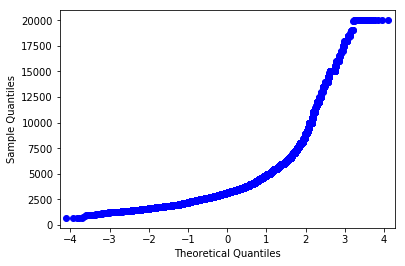

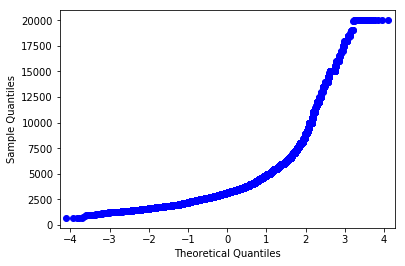

In [84]:
sm.qqplot(price, loc=price.mean(), scale=price.std())

Q-Q plot after StandardScaler. Shape doesn’t change

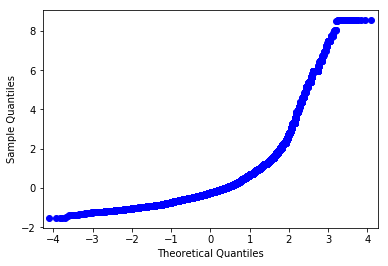

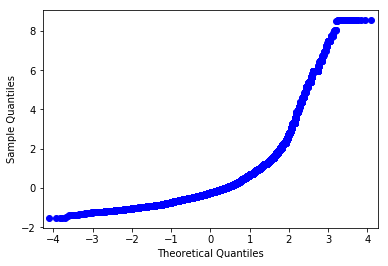

In [85]:
sm.qqplot(price_z, loc=price_z.mean(), scale=price_z.std())

Q-Q plot after MinMaxScaler. Shape doesn’t change

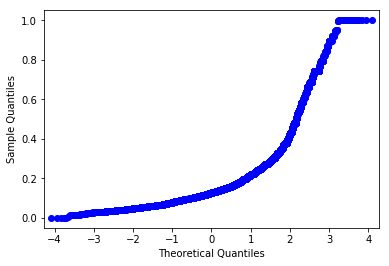

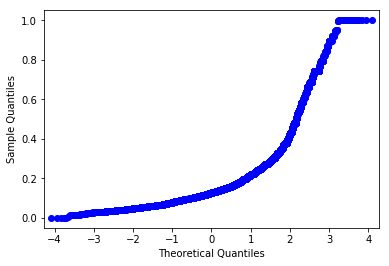

In [86]:
sm.qqplot(price_mm, loc=price_mm.mean(), scale=price_mm.std())

Q-Q plot after taking the logarithm. Things are getting better!

In [90]:
shapiro(price), shapiro(price_mm), shapiro(price_z), shapiro(price_log)

D:\ML\tools\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


((0.7429875135421753, 0.0),
 (0.7429936528205872, 0.0),
 (0.7429871559143066, 0.0),
 (0.9705549478530884, 0.0))

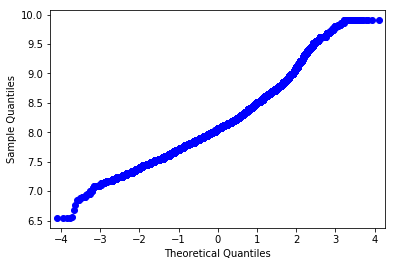

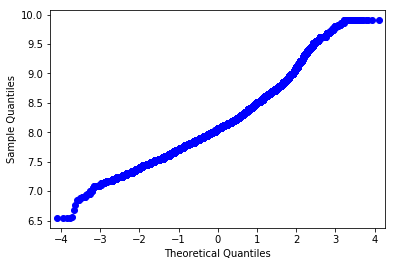

In [87]:
sm.qqplot(price_log, loc=price_log.mean(), scale=price_log.std())

In [92]:
from scipy import stats
x = stats.norm.rvs(loc=5, scale=3, size=100)

In [95]:
y = stats.norm.rvs(size=1000)

In [96]:
shapiro(x), shapiro(y)

((0.9856409430503845, 0.35287782549858093),
 (0.9971408247947693, 0.07213372737169266))

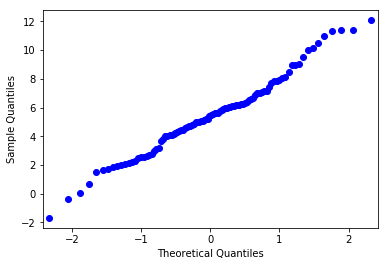

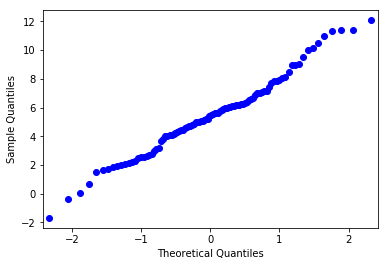

In [94]:
sm.qqplot(x, loc=x.mean(), scale=x.std())

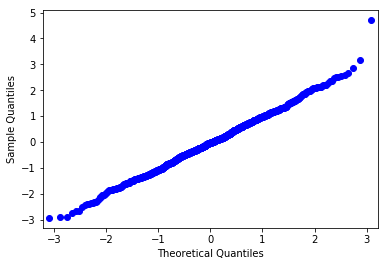

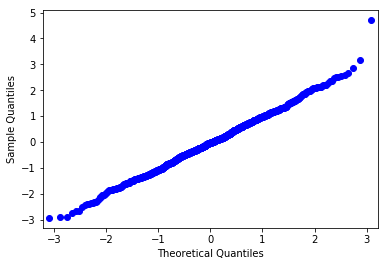

In [97]:
sm.qqplot(y, loc=y.mean(), scale=y.std())

Let’s see whether transformations can somehow help the real model. There is no silver bullet here.

In [106]:
import demo
from imp import reload
reload(demo)
x_data, y_data = demo.get_data()

In [107]:
x_data.head(5)

,bathrooms,bedrooms,price,dishwasher,doorman,pets,air_conditioning,parking,balcony,bike,...,stainless,simplex,public,num_photos,num_features,listing_age,room_dif,room_sum,price_per_room,bedrooms_share
10,1.5,3,8.006368,0,0,0,0,0,0,0,...,0,0,0,5,0,638,1.5,4.5,666.666667,0.666667
10000,1.0,2,8.606119,0,1,1,0,0,0,0,...,0,0,0,11,57,650,1.0,3.0,1821.666667,0.666667
100004,1.0,1,7.955074,1,0,1,0,0,0,0,...,0,0,0,8,72,706,0.0,2.0,1425.000000,0.500000
100007,1.0,1,8.094073,0,0,0,0,0,0,0,...,0,0,0,3,22,705,0.0,2.0,1637.500000,0.500000
100013,1.0,4,8.116716,0,0,0,0,0,0,0,...,0,0,0,3,7,695,3.0,5.0,670.000000,0.800000


In [108]:
x_data = x_data.values

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

In [113]:
from sklearn.preprocessing import StandardScaler

In [112]:
cross_val_score(LogisticRegression(), x_data, y_data, scoring='neg_log_loss').mean()

-0.6855956341675985

In [130]:
cross_val_score(LogisticRegression(), StandardScaler().fit_transform(x_data), y_data, scoring='neg_log_loss').mean()

-0.66985175441424749

In [131]:
cross_val_score(LogisticRegression(), (x_data - x_data.mean()) / x_data.std(), y_data, scoring='neg_log_loss').mean()

-0.75343607703274085

In [132]:
cross_val_score(LogisticRegression(), StandardScaler().fit_transform(MinMaxScaler().fit_transform(x_data)), y_data, scoring='neg_log_loss').mean()

-0.6698516626692107

In [133]:
cross_val_score(LogisticRegression(), MinMaxScaler().fit_transform(StandardScaler().fit_transform(x_data)), y_data, scoring='neg_log_loss').mean()

-0.68522453126702765

In [116]:
(x_data - x_data.mean()) / x_data.std()

array([[-0.04179255, -0.0405331 , -0.03632959, ..., -0.03927365,
         0.51670273, -0.04249224],
       [-0.04221236, -0.04137273, -0.03582602, ..., -0.0405331 ,
         1.48647779, -0.04249224],
       [-0.04221236, -0.04221236, -0.03637266, ..., -0.04137273,
         1.15342373, -0.04263218],
       ..., 
       [-0.04221236, -0.04221236, -0.03645136, ..., -0.04137273,
         1.04637064, -0.04263218],
       [-0.04221236, -0.043052  , -0.03623694, ..., -0.04221236,
         2.76971549, -0.043052  ],
       [-0.04221236, -0.04137273, -0.03659001, ..., -0.0405331 ,
         0.5726782 , -0.04249224]])

In [120]:
StandardScaler().fit_transform(x_data)

array([[ 0.57813095,  1.31388377, -0.2140884 , ...,  1.21385624,
        -0.1169741 ,  0.78024599],
       [-0.42513635,  0.41365203,  1.17155264, ...,  0.17199059,
         0.02926955,  0.78024599],
       [-0.42513635, -0.48657971, -0.33259424, ..., -0.52258651,
        -0.02095554,  0.10679404],
       ..., 
       [-0.42513635, -0.48657971, -0.54914975, ..., -0.52258651,
        -0.03709932,  0.10679404],
       [-0.42513635, -1.38681144,  0.04085504, ..., -1.21716362,
         0.22278386, -1.91356181],
       [-0.42513635,  0.41365203, -0.93065711, ...,  0.17199059,
        -0.10853291,  0.78024599]])

In [121]:
x_data

array([[  1.50000000e+00,   3.00000000e+00,   8.00636757e+00, ...,
          4.50000000e+00,   6.66666667e+02,   6.66666667e-01],
       [  1.00000000e+00,   2.00000000e+00,   8.60611940e+00, ...,
          3.00000000e+00,   1.82166667e+03,   6.66666667e-01],
       [  1.00000000e+00,   1.00000000e+00,   7.95507428e+00, ...,
          2.00000000e+00,   1.42500000e+03,   5.00000000e-01],
       ..., 
       [  1.00000000e+00,   1.00000000e+00,   7.86134180e+00, ...,
          2.00000000e+00,   1.29750000e+03,   5.00000000e-01],
       [  1.00000000e+00,   0.00000000e+00,   8.11671563e+00, ...,
          1.00000000e+00,   3.35000000e+03,   0.00000000e+00],
       [  1.00000000e+00,   2.00000000e+00,   7.69621264e+00, ...,
          3.00000000e+00,   7.33333333e+02,   6.66666667e-01]])

In [122]:
from sklearn.preprocessing import MinMaxScaler

### Interactions

If previous transformations seemed rather math-driven, this part is more about the nature of the data; it can be attributed to both feature transformations and feature creation.

Let’s come back again to the Two Sigma Connect: Rental Listing Inquiries problem. Among the features in this problem are the number of rooms and the price. Logic suggests that the cost per single room is more indicative than the total cost, so we can generate such a feature.

In [128]:
rooms = df["bedrooms"].apply(lambda x: max(x, .5))
# Avoid division by zero; .5 is chosen more or less arbitrarily
df["price_per_bedroom"] = df["price"] / rooms

In [129]:
type(rooms)

pandas.core.series.Series

You should limit yourself in this process. If there are a limited number of features, it is possible to generate all the possible interactions and then weed out the unnecessary ones using the techniques described in the next section. In addition, not all interactions between features must have a physical meaning; for example, polynomial features (see [sklearn.preprocessing.PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are often used in linear models and are almost impossible to interpret.

### Filling in the missing values

Not many algorithms can work with missing values, and the real world often provides data with gaps. Fortunately, this is one of the tasks for which one doesn’t need any creativity. Both key python libraries for data analysis provide easy-to-use solutions: [pandas.DataFrame.fillna](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) and [sklearn.preprocessing.Imputer](http://scikit-learn.org/stable/modules/preprocessing.html#imputation).

These solutions do not have any magic happening behind the scenes. Approaches to handling missing values are pretty straightforward:

* encode missing values with a separate blank value like `"n/a"` (for categorical variables);
* use the most probable value of the feature (mean or median for the numerical variables, the most common value for categorical variables);
* or, conversely, encode with some extreme value (good for decision-tree models since it allows the model to make a partition between the missing and non-missing values);
* for ordered data (e.g. time series), take the adjacent value — next or previous.

![image](https://cdn-images-1.medium.com/max/800/0*Ps-v8F0fBgmnG36S.)

Easy-to-use library solutions sometimes suggest sticking to something like `df = df.fillna(0)` and not sweat the gaps. But this is not the best solution: data preparation takes more time than building models, so thoughtless gap-filling may hide a bug in processing and damage the model.

## Feature selection

Why would it even be necessary to select features? To some, this idea may seem counterintuitive, but there are at least two important reasons to get rid of unimportant features. The first is clear to every engineer: the more data, the higher the computational complexity. As long as we work with toy datasets, the size of the data is not a problem, but, for real loaded production systems, hundreds of extra features will be quite tangible. The second reason is that some algorithms take noise (non-informative features) as a signal and overfit.

### Statistical approaches

The most obvious candidate for removal is a feature whose value remains unchanged, i.e., it contains no information at all. If we build on this thought, it is reasonable to say that features with low variance are worse than those with high variance. So, one can consider cutting features with variance below a certain threshold.

In [134]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification()
x_data_generated.shape

(100, 20)

In [147]:
x_data_generated

array([[-0.47804795,  1.19812113,  1.16817847, ..., -0.29801499,
        -0.69985115,  1.15559886],
       [ 1.01571878, -0.91939737,  0.75592436, ...,  0.05786296,
        -0.01647081,  1.20642254],
       [ 1.19534222,  1.47015501, -0.13274288, ...,  0.8679765 ,
         0.29618208,  0.06594986],
       ..., 
       [-0.71605701, -0.56555825,  0.3799651 , ..., -0.19364361,
         0.41447956,  1.27707817],
       [ 0.31210606,  0.40309737,  1.00538205, ..., -1.2357883 ,
        -1.10178671,  0.55372411],
       [ 0.16968396, -0.54657821, -2.70231418, ..., -1.36728717,
        -1.34193744,  0.86549327]])

In [150]:
for i in range(20):
    print (np.var(x_data_generated[:,i]), x_data_generated[:,i].shape)

0.928456531952 (100,)
1.10018674442 (100,)
0.931502742845 (100,)
0.748976672085 (100,)
1.17351399608 (100,)
0.962707454262 (100,)
0.979879945915 (100,)
0.199633634288 (100,)
0.952160747887 (100,)
1.13357013173 (100,)
1.62117196865 (100,)
0.941242891468 (100,)
1.06644265407 (100,)
0.908129990635 (100,)
1.12563767282 (100,)
0.822355018075 (100,)
1.50650649094 (100,)
1.26502786377 (100,)
0.746834128425 (100,)
1.03307764592 (100,)


In [160]:
VarianceThreshold(.7).fit(x_data_generated).get_support()

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True], dtype=bool)

In [140]:
VarianceThreshold(.7).fit_transform(x_data_generated).shape

(100, 19)

In [161]:
VarianceThreshold(.8).fit(x_data_generated).get_support()

array([ True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True], dtype=bool)

In [137]:
VarianceThreshold(.8).fit_transform(x_data_generated).shape

(100, 17)

In [162]:
VarianceThreshold(.9).fit(x_data_generated).get_support()

array([ True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True], dtype=bool)

In [138]:
VarianceThreshold(.9).fit_transform(x_data_generated).shape

(100, 16)

In [170]:
VarianceThreshold(1.0).fit_transform(x_data_generated).shape

(100, 9)

There are other ways that are also [based on classical statistics](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

In [174]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)
x_data_varth8 = VarianceThreshold(.8).fit_transform(x_data_generated)
x_data_varth1 = VarianceThreshold(1.0).fit_transform(x_data_generated)
x_data_kbest1 = SelectKBest(f_classif, k=5).fit_transform(x_data_varth1, y_data_generated)

In [197]:
x_data_kbest_top = SelectKBest(f_classif, k=1).fit_transform(x_data_generated, y_data_generated)

In [198]:
cross_val_score(LogisticRegression(), x_data_kbest_top, y_data_generated, scoring='neg_log_loss').mean()

-0.26447053366296552

In [165]:
cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring='neg_log_loss').mean()

-0.41119505498117487

In [166]:
cross_val_score(LogisticRegression(), x_data_kbest, y_data_generated, scoring='neg_log_loss').mean()

-0.28363762642297868

In [167]:
cross_val_score(LogisticRegression(), x_data_varth, y_data_generated, scoring='neg_log_loss').mean()

-0.37056836836930068

In [169]:
cross_val_score(LogisticRegression(), x_data_varth8, y_data_generated, scoring='neg_log_loss').mean()

-0.3914197941700111

In [173]:
cross_val_score(LogisticRegression(), x_data_varth1, y_data_generated, scoring='neg_log_loss').mean()

-0.30374077510470504

In [178]:
cross_val_score(LogisticRegression(), x_data_kbest1, y_data_generated, scoring='neg_log_loss').mean()

-0.27394679517073128

We can see that our selected features have improved the quality of the classifier. Of course, this example is purely artificial; however, it is worth using for real problems.

### Selection by modeling

Another approach is to use some baseline model for feature evaluation because the model will clearly show the importance of the features. Two types of models are usually used: some “wooden” composition such as [Random Forest](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-5-ensembles-of-algorithms-and-random-forest-8e05246cbba7) or a linear model with Lasso regularization so that it is prone to nullify weights of weak features. The logic is intuitive: if features are clearly useless in a simple model, there is no need to drag them to a more complex one.

In [203]:
# Synthetic example

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

x_data_generated, y_data_generated = make_classification()

pipe = make_pipeline(SelectFromModel(estimator=RandomForestClassifier()), LogisticRegression())

lr = LogisticRegression()
rf = RandomForestClassifier()

print(cross_val_score(lr, x_data_generated, y_data_generated, scoring='neg_log_loss').mean())
print(cross_val_score(rf, x_data_generated, y_data_generated, scoring='neg_log_loss').mean())
print(cross_val_score(pipe, x_data_generated, y_data_generated, scoring='neg_log_loss').mean())

-0.247774732327
-1.48179598504
-0.19207651634


In [252]:
print (SelectFromModel(estimator=RandomForestClassifier()).fit(x_data_generated, y_data_generated).get_support())
xsfm = SelectFromModel(estimator=RandomForestClassifier()).fit_transform(x_data_generated, y_data_generated)
cross_val_score(LogisticRegression(), xsfm, y_data_generated, scoring='neg_log_loss').mean()

[False False False False False False  True False False False False False
 False False  True False False False False False]


-0.18199245353336679

In [247]:
print (SelectKBest(f_classif, k=4).fit(x_data_generated, y_data_generated).get_support())
xskb = SelectKBest(f_classif, k=4).fit_transform(x_data_generated, y_data_generated)
cross_val_score(LogisticRegression(), xskb, y_data_generated, scoring='neg_log_loss').mean()

[False False  True False False  True  True False False False False False
 False False  True False False False False False]


-0.20751380606329498

In [336]:
np.random.RandomState(1)
np.random.seed(1)
print (SelectKBest(f_classif, k=2).fit(x_data_generated, y_data_generated).get_support())
xskb = SelectKBest(f_classif, k=2).fit_transform(x_data_generated, y_data_generated)
print (cross_val_score(LogisticRegression(random_state=1), xskb, y_data_generated, scoring='neg_log_loss'))

[False False False False False  True False False False False False False
 False False  True False False False False False]
[-0.18458548 -0.27958422 -0.09527624]


In [337]:
np.random.RandomState(1)
np.random.seed(1)
pipek = make_pipeline(SelectKBest(f_classif, k=2), LogisticRegression(random_state=1))
print (pipek.named_steps.selectkbest.fit(x_data_generated, y_data_generated).get_support())
print(cross_val_score(pipek, x_data_generated, y_data_generated, scoring='neg_log_loss'))

[False False False False False  True False False False False False False
 False False  True False False False False False]
[-0.18716209 -0.27958422 -0.09527624]


[False False False False False  True False False False False False False
 False False  True False False False False False]


We must not forget that this is not a silver bullet again - it can make the performance worse.

In [326]:
#x_data, y_data = get_data() 
x_data = x_data_generated
y_data = y_data_generated

pipe1 = make_pipeline(StandardScaler(), SelectFromModel(estimator=RandomForestClassifier()), LogisticRegression())

pipe2 = make_pipeline(StandardScaler(), LogisticRegression())

rf = RandomForestClassifier()

print('LR + selection: ', cross_val_score(pipe1, x_data, y_data, scoring='neg_log_loss').mean())
print('LR: ', cross_val_score(pipe2, x_data, y_data, scoring='neg_log_loss').mean())
print('RF: ', cross_val_score(rf, x_data, y_data, scoring='neg_log_loss').mean())

LR + selection:  -0.180674195326
LR:  -0.237971080805
RF:  -0.552936480968


It got worse!

### Grid search
Finally, we get to the most reliable method, which is also the most computationally complex: trivial grid search. Train a model on a subset of features, store results, repeat for different subsets, and compare the quality of models to identify the best feature set. This approach is called [Exhaustive Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/).

Searching all combinations usually takes too long, so you can try to reduce the search space. Fix a small number N, iterate through all combinations of N features, choose the best combination, and then iterate through the combinations of (N + 1) features so that the previous best combination of features is fixed and only a single new feature is considered. It is possible to iterate until we hit a maximum number of characteristics or until the quality of the model ceases to increase significantly. This algorithm is called [Sequential Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/).

This algorithm can be reversed: start with the complete feature space and remove features one by one until it does not impair the quality of the model or until the desired number of features is reached.

In [344]:
from mlxtend.feature_selection import SequentialFeatureSelector

selector2 = SequentialFeatureSelector(RandomForestClassifier(), scoring='neg_log_loss', 
                                     verbose=2, k_features=3, forward=False, n_jobs=-1)

selector2.fit(x_data, y_data)

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    2.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.1s finished

[2018-03-25 16:34:11] Features: 19/3 -- score: -0.270120481845[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    1.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.7s finished

[2018-03-25 16:34:13] Features: 18/3 -- score: -0.240044979532[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished

[2018-03-25 16:34:15] Features: 17/3 -- score: -0.378014988836[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    1.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.7s finished

[2018-03-25 16:34:17] Features: 16/3 -- score: -0.311396631515[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    1.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
             floating=False, forward=False, k_features=3, n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring='neg_log_loss', verbose=2)

In [339]:
# Install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(LogisticRegression(), scoring='neg_log_loss', 
                                     verbose=2, k_features=3, forward=False, n_jobs=-1)

selector.fit(x_data, y_data)

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   16.4s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   16.4s finished

[2018-03-25 16:07:01] Features: 19/3 -- score: -0.216460226915[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    1.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.4s finished

[2018-03-25 16:07:03] Features: 18/3 -- score: -0.203046305922[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.6s finished

[2018-03-25 16:07:05] Features: 17/3 -- score: -0.190444264924[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    1.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.6s finished

[2018-03-25 16:07:07] Features: 16/3 -- score: -0.183565863635[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    1.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             floating=False, forward=False, k_features=3, n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring='neg_log_loss', verbose=2)

best combination (ACC: -0.546): (4, 14, 18)

all subsets:
 {20: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19), 'cv_scores': array([-1.7993162 , -1.84490802, -3.64727343, -0.10845472, -0.1864871 ]), 'avg_score': -1.5172878945080925}, 19: {'feature_idx': (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19), 'cv_scores': array([-0.27222702, -0.2969278 , -0.46192759, -0.20375615, -0.11576384]), 'avg_score': -0.27012048184493265}, 18: {'feature_idx': (0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19), 'cv_scores': array([-0.17595105, -0.29491896, -0.37643122, -0.13988515, -0.21303852]), 'avg_score': -0.24004497953156151}, 17: {'feature_idx': (0, 1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19), 'cv_scores': array([-0.37642182, -0.44777764, -0.46216174, -0.37278505, -0.23092869]), 'avg_score': -0.37801498883571838}, 16: {'feature_idx': (0, 1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19), 'cv_scores': array([-0.

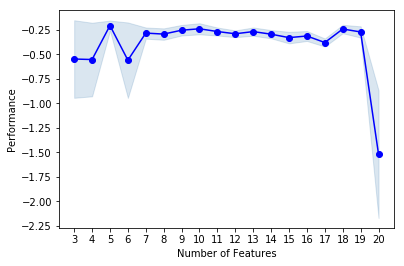

In [345]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
print('best combination (ACC: %.3f): %s\n' % (selector2.k_score_, selector2.k_feature_idx_))
print('all subsets:\n', selector2.subsets_)
plot_sfs(selector2.get_metric_dict(), kind='std_err');

best combination (ACC: -0.163): (9, 14, 19)

all subsets:
 {20: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19), 'cv_scores': array([-0.23428566, -0.22113873, -0.4567555 , -0.05919857, -0.21177748]), 'avg_score': -0.2366311864290101}, 19: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19), 'cv_scores': array([-0.21231644, -0.22930944, -0.46087816, -0.06238578, -0.11741131]), 'avg_score': -0.21646022691450142}, 18: {'feature_idx': (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19), 'cv_scores': array([-0.16154851, -0.21141464, -0.45855208, -0.06382335, -0.11989296]), 'avg_score': -0.20304630592163875}, 17: {'feature_idx': (0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19), 'cv_scores': array([-0.12536822, -0.21311101, -0.43324845, -0.05971753, -0.12077613]), 'avg_score': -0.19044426492441552}, 16: {'feature_idx': (1, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19), 'cv_scores': array([-0.

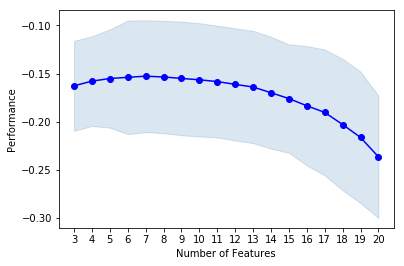

In [343]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
sfs1 = selector
print('best combination (ACC: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))
print('all subsets:\n', sfs1.subsets_)
plot_sfs(sfs1.get_metric_dict(), kind='std_err');

In [340]:
selector.subsets_

{3: {'avg_score': -0.16280168820353566,
  'cv_scores': array([-0.11902273, -0.19305217, -0.33220858, -0.07948906, -0.09023589]),
  'feature_idx': (9, 14, 19)},
 4: {'avg_score': -0.15793325730584934,
  'cv_scores': array([-0.12099312, -0.1840501 , -0.32778925, -0.0747413 , -0.08209251]),
  'feature_idx': (6, 9, 14, 19)},
 5: {'avg_score': -0.15519502446975167,
  'cv_scores': array([-0.10637859, -0.19109882, -0.33914886, -0.06304501, -0.07630383]),
  'feature_idx': (5, 6, 9, 14, 19)},
 6: {'avg_score': -0.15395841017323378,
  'cv_scores': array([-0.09441715, -0.17117202, -0.37598958, -0.04969558, -0.07851772]),
  'feature_idx': (5, 6, 9, 14, 18, 19)},
 7: {'avg_score': -0.15277447478573242,
  'cv_scores': array([-0.09995093, -0.16691774, -0.3720047 , -0.049625  , -0.075374  ]),
  'feature_idx': (5, 6, 7, 9, 14, 18, 19)},
 8: {'avg_score': -0.153617801137855,
  'cv_scores': array([-0.09978351, -0.17025313, -0.373201  , -0.04964933, -0.07520203]),
  'feature_idx': (5, 6, 7, 9, 10, 14, 18,

По графику и просто глазами видим лучший кейс:
`7: {'avg_score': -0.15277447478573242,
  'cv_scores': array([-0.09995093, -0.16691774, -0.3720047 , -0.049625  , -0.075374  ]),
  'feature_idx': (5, 6, 7, 9, 14, 18, 19)},`

In [341]:
selector.k_feature_idx_

(9, 14, 19)

In [346]:
# Install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(LogisticRegression(), scoring='neg_log_loss', 
                                     k_features=7, forward=False, n_jobs=-1)

selector.fit(x_data, y_data)

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             floating=False, forward=False, k_features=7, n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring='neg_log_loss', verbose=0)

best combination (ACC: -0.153): (5, 6, 7, 9, 14, 18, 19)



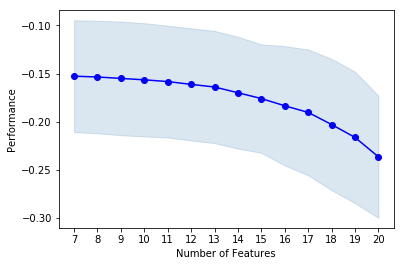

In [347]:
print('best combination (ACC: %.3f): %s\n' % (selector.k_score_, selector.k_feature_idx_))
plot_sfs(selector.get_metric_dict(), kind='std_err');

In [39]:
# Install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(LogisticRegression(), scoring='neg_log_loss', 
                                     verbose=2, k_features=3, forward=False, n_jobs=-1)

selector.fit(x_data, y_data)

[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished

[2018-03-15 14:06:36] Features: 19/3 -- score: -0.291776207828[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.1s finished

[2018-03-15 14:06:37] Features: 18/3 -- score: -0.271655018865[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.1s finished

[2018-03-15 14:06:37] Features: 17/3 -- score: -0.256889533289[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             floating=False, forward=False, k_features=3, n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring='neg_log_loss', verbose=2)

Take a look how this approach was done in one [simple yet elegant Kaggle kernel](https://www.kaggle.com/arsenyinfo/easy-feature-selection-pipeline-0-55-at-lb).